In [1]:
# Import libraries
import pandas as pd
import numpy as np
# %matplotlib inline
from datetime import datetime
import matplotlib.pyplot as plt

# Load specific forecasting tools
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

# Load specific evaluation tools
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")


In [2]:
# Load datasets
car = pd.read_csv('car.csv')
                    
# Add the date column
car['Year'] = car.index // 12 + 2004
car['Month'].apply(lambda x: datetime.strptime(str(x), '%b-%d'))

car['mon'] = car['Month'].apply(lambda x: datetime.strptime(x, '%b-%d'))
car['month'] = car['mon'].dt.month
car['day'] = car['mon'].dt.day
car = car.drop(columns='mon')
car['date'] = pd.to_datetime({'year':car['Year'],'month':car['month'],'day': 1})
car = car.drop(columns=['Year','month', 'day', 'Month'])

car['date'] = pd.to_datetime(car['date'])
car = car.set_index('date')

# rename columns
car.columns = ['prop']
car.head()

,prop
date,
2004-01-01,83
2004-02-01,82
2004-03-01,87
2004-04-01,91
2004-05-01,96


In [3]:
# split the data into train/test sets
train=car.iloc[:(len(car) - 18)] # a year and a half
test=car.iloc[(len(car) - 18):]

print("train.shape: ")
print(train.shape)

train.shape: 
(179, 1)


In [4]:
# scale data
scaler = MinMaxScaler()
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [5]:
# define generator 
past = 12 # for each month, we use its past 12 months data to predic the next month
features = 1 
generator = TimeseriesGenerator(scaled_train, scaled_train, length=past, batch_size=features)

In [6]:
# create the Model
model = Sequential()
model.add(LSTM(8, activation='relu', input_shape=(past, features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 8)                 320       
_________________________________________________________________
dense (Dense)                (None, 1)                 9         
Total params: 329
Trainable params: 329
Non-trainable params: 0
_________________________________________________________________


In [7]:
model.fit_generator(generator,epochs=25)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/25
167/167 [==============================] - 1s 6ms/step - loss: 0.0332
Epoch 2/25
167/167 [==============================] - 1s 6ms/step - loss: 0.0277
Epoch 3/25
167/167 [==============================] - 1s 6ms/step - loss: 0.0268
Epoch 4/25
167/167 [==============================] - 1s 7ms/step - loss: 0.0250
Epoch 5/25
167/167 [==============================] - 1s 6ms/step - loss: 0.0215
Epoch 6/25
167/167 [==============================] - 1s 6ms/step - loss: 0.0156
Epoch 7/25
167/167 [==============================] - 1s 5ms/step - loss: 0.0105
Epoch 8/25
167/167 [==============================] - 1s 5ms/step - loss: 0.0106
Epoch 9/25
167/167 [==============================] - 1s 5ms/step - loss: 0.0077
Epoch 10/25
167/167 [==============================] - 1s 5ms/step - loss: 0.0073
Epoch 11/25
167/167 [==============================] - 1s 5ms/step - loss: 0.0064
Epoch 12/25
167/167 [==========

In [8]:
# Evaluate test data
def predictn(data):
    mypred = []
    eval_batch1 = scaled_train[-past:]
    cur_batch = eval_batch1.reshape((1, past, features))
    for i in range(len(data)):    
        new_pred = model.predict(cur_batch)[0]
        mypred.append(new_pred) 
        cur_batch = np.append(cur_batch[:,1:,:],[[new_pred]],axis=1)
    return mypred


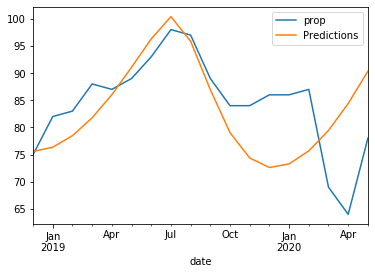

In [9]:
pred_test = predictn(test)
inv_pred_test = scaler.inverse_transform(pred_test)

# compare actual test and our predictions
test['Predictions'] = inv_pred_test
test.plot()

### Predict one year into the future

In [10]:
train=car.iloc[:len(car)]
test = car.iloc[len(car)-12:] # need the shape of it, value does not matter
    
# scale data
scaler = MinMaxScaler()
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)
                 

In [11]:
# define generator 
past = 12
features = 1 
generator = TimeseriesGenerator(scaled_train, scaled_train, length=past, batch_size=features)

In [12]:
# create the Model
model = Sequential()
model.add(LSTM(8, activation='relu', input_shape=(past, features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 8)                 320       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 329
Trainable params: 329
Non-trainable params: 0
_________________________________________________________________


In [13]:
model.fit_generator(generator,epochs=25)

Epoch 1/25
185/185 [==============================] - 1s 7ms/step - loss: 0.0452
Epoch 2/25
185/185 [==============================] - 1s 7ms/step - loss: 0.0281
Epoch 3/25
185/185 [==============================] - 2s 8ms/step - loss: 0.0272
Epoch 4/25
185/185 [==============================] - 2s 10ms/step - loss: 0.0248
Epoch 5/25
185/185 [==============================] - 2s 10ms/step - loss: 0.0215
Epoch 6/25
185/185 [==============================] - 1s 8ms/step - loss: 0.0161
Epoch 7/25
185/185 [==============================] - 1s 7ms/step - loss: 0.0114
Epoch 8/25
185/185 [==============================] - 2s 8ms/step - loss: 0.0115
Epoch 9/25
185/185 [==============================] - 1s 8ms/step - loss: 0.0112
Epoch 10/25
185/185 [==============================] - 2s 12ms/step - loss: 0.0112
Epoch 11/25
185/185 [==============================] - 2s 11ms/step - loss: 0.0110
Epoch 12/25
185/185 [==============================] - 2s 12ms/step - loss: 0.0099
Epoch 13/25
185/185 

In [14]:
# Evaluate test data
def predictn(data):
    mypred = []
    eval_batch1 = scaled_train[-past:]
    cur_batch = eval_batch1.reshape((1, past, features))
    for i in range(len(data)):    
        new_pred = model.predict(cur_batch)[0]
        mypred.append(new_pred) 
        cur_batch = np.append(cur_batch[:,1:,:],[[new_pred]],axis=1)
    return mypred

In [15]:
pred_test = predictn(test)
inv_pred_test = scaler.inverse_transform(pred_test)

In [16]:
# rename columns
car.columns = ['prop']
car.tail()

,prop
date,
2020-01-01,86
2020-02-01,87
2020-03-01,69
2020-04-01,64
2020-05-01,78


In [17]:
def predictn_dates(n):
    last = car.index.values[-1]
    start = last + np.timedelta64(1,'D')
    pred_dates = pd.date_range(start=start, periods=n, freq='MS').tolist()
    return pred_dates

In [18]:
n = 12 # predict one year
pred_dates = predictn_dates(n)


In [19]:
inv_pred_test # convert to lst
len_inv = len(inv_pred_test)
lst = [0] * (len_inv)
for i in range(len_inv):
    lst[i] = inv_pred_test[i][0]
#pre_ser = pd.Series(arr)  

In [20]:
ser = pd.Series(lst, index=pred_dates)
ser

2020-06-01    76.756198
2020-07-01    78.132980
2020-08-01    79.363201
2020-09-01    80.841340
2020-10-01    82.546280
2020-11-01    83.937518
2020-12-01    83.494046
2021-01-01    80.282714
2021-02-01    76.105250
2021-03-01    72.426314
2021-04-01    70.850077
2021-05-01    70.564605
dtype: float64

In [21]:
df2 = pd.DataFrame(ser, columns=['prop'])
df2.head()

,prop
2020-06-01,76.756198
2020-07-01,78.132980
2020-08-01,79.363201
2020-09-01,80.841340
2020-10-01,82.546280


<Figure size 432x288 with 0 Axes>

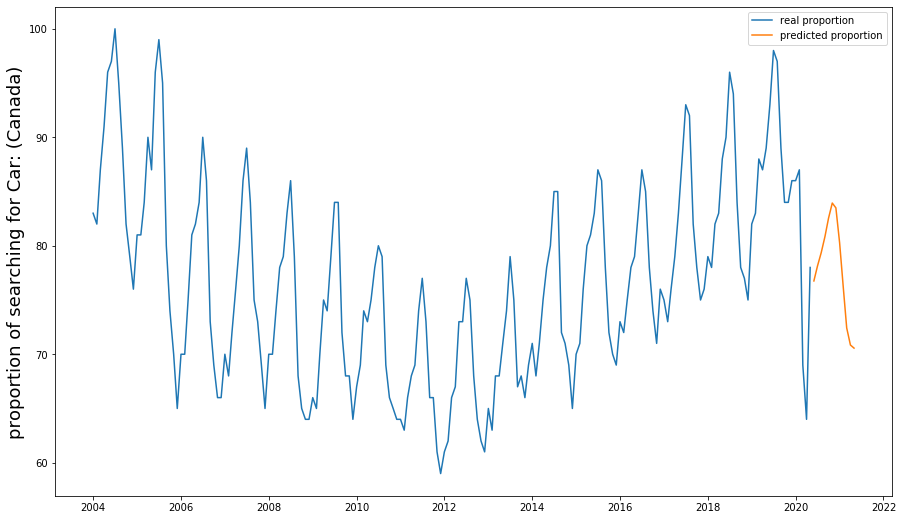

In [22]:
fig = plt.figure()
plt.figure(figsize=(15,9))
plt.plot(train, label = 'real proportion')
plt.plot(df2, label = 'predicted proportion')
plt.ylabel('proportion of searching for Car: (Canada)', fontsize=18)
plt.legend()
plt.show()
# fig.savefig('predict.jpg')